In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_fullver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'train_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_train_FNs.npy'))
    return images, labels, filenames


def load_testing():
    images = np.load(os.path.join('../Data_final_fullver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'test_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_test_FNs.npy'))
    return images, labels, filenames

In [3]:
train_images, train_labels, Fn= load_training()
test_images, test_labels, Fn= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2925 	 Test size: 643
Image size: 256x256


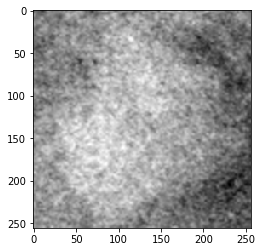

Label: 1
FN: Mass-Training_P_00106_LEFT_CC.png


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
print("FN: " + str(Fn[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(2925, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_resnet101(verbose=False, fc_size=256, output = 2, dropout=None):
    
    resnet101_base = ResNet101(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    resnet101 = models.Sequential()
    resnet101.add(resnet101_base)

    resnet101.add(layers.Flatten())
    if dropout is not None:
        resnet101.add(layers.Dropout(dropout))
    resnet101.add(layers.Dense(fc_size, activation='relu'))
    resnet101.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    resnet101_base.trainable = False
    
    if verbose:
        resnet101_base.summary()
        resnet101.summary()

    return resnet101

In [12]:
resnet = ResNet101(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in resnet.layers:
    layer.trainable = False
resnet_maxpool = resnet.get_layer('conv5_block3_out').output
FeatureFlatten = Flatten()(resnet_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_resnet = Model(inputs = resnet.input, outputs = predictions)
new_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
resnet101_calc_or_mass_best_Adam = new_resnet

In [14]:
resnet101_calc_or_mass_best_RMSprop = new_resnet

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_calc_or_mass_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_calc_or_mass_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_resnet101_calc_or_mass_best_Adam = resnet101_calc_or_mass_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 3.7420 - recall: 0.5505
Epoch 00001: val_loss improved from inf to 0.63462, saving model to ../model/resnet101_calc_or_mass_best_Adam.h5
11/11 [==============================] - 28s 3s/step - loss: 3.3671 - recall: 0.5578 - val_loss: 0.6346 - val_recall: 0.6752
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6520 - recall: 0.7109
Epoch 00002: val_loss improved from 0.63462 to 0.52041, saving model to ../model/resnet101_calc_or_mass_best_Adam.h5
11/11 [==============================] - 23s 2s/step - loss: 0.6275 - recall: 0.7158 - val_loss: 0.5204 - val_recall: 0.7333
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4739 - recall: 0.7938
Epoch 00003: val_loss did not improve from 0.52041
11/11 [================

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3258 - recall: 0.8535
Epoch 00028: val_loss did not improve from 0.45185
11/11 [==============================] - 21s 2s/step - loss: 0.3308 - recall: 0.8541 - val_loss: 0.4904 - val_recall: 0.7915
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3097 - recall: 0.8727
Epoch 00029: val_loss did not improve from 0.45185
11/11 [==============================] - 22s 2s/step - loss: 0.3104 - recall: 0.8679 - val_loss: 0.5167 - val_recall: 0.7778
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3564 - recall: 0.8443
Epoch 00030: val_loss did not improve from 0.45185
11/11 [==============================] - 20s 2s/step - loss: 0.3548 - recall: 0.8427 - val_loss: 0.6088 - val_recall: 0.7590
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3565 - recall: 0.8460
Epoch 00031: val_loss did not improve from 0.45185
11/11 [==============================] - 21s 

Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3245 - recall: 0.8552
Epoch 00058: val_loss did not improve from 0.42421
11/11 [==============================] - 20s 2s/step - loss: 0.3236 - recall: 0.8594 - val_loss: 0.4647 - val_recall: 0.8034
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3102 - recall: 0.8680
Epoch 00059: val_loss did not improve from 0.42421
11/11 [==============================] - 22s 2s/step - loss: 0.3242 - recall: 0.8643 - val_loss: 0.4483 - val_recall: 0.8171
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3064 - recall: 0.8680
Epoch 00060: val_loss did not improve from 0.42421
11/11 [==============================] - 21s 2s/step - loss: 0.2971 - recall: 0.8722 - val_loss: 0.4646 - val_recall: 0.7812
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2958 - recall: 0.8820
Epoch 00061: val_loss did not improve from 0.42421
11/11 [==============================] - 22s 

In [17]:
models.save_model(resnet101_calc_or_mass_best_Adam, '../model/resnet101_calc_or_mass_end_Adam.h5')

In [18]:
tra_loss_fe = history_resnet101_calc_or_mass_best_Adam.history['loss']
tra_acc_fe = history_resnet101_calc_or_mass_best_Adam.history['recall']
val_loss_fe = history_resnet101_calc_or_mass_best_Adam.history['val_loss']
val_acc_fe = history_resnet101_calc_or_mass_best_Adam.history['val_recall']

In [19]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_calc_or_mass = models.load_model('../model/resnet101_calc_or_mass_best_Adam.h5')
test_loss_fe, test_acc_fe = resnet101_calc_or_mass_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

In [20]:
print("resnet101 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 calc or mass

Epoch [end]: 92
Epoch [opt]: 62
Valid recall [end]: 0.7880
Valid recall [opt]: 0.8205
Test recall [end]:  0.7496
Test recall [opt]:  0.7776
Valid loss [end]: 0.4714
Valid loss [opt]: 0.4067
Test loss [end]:  0.5407
Test loss [opt]:  0.4783


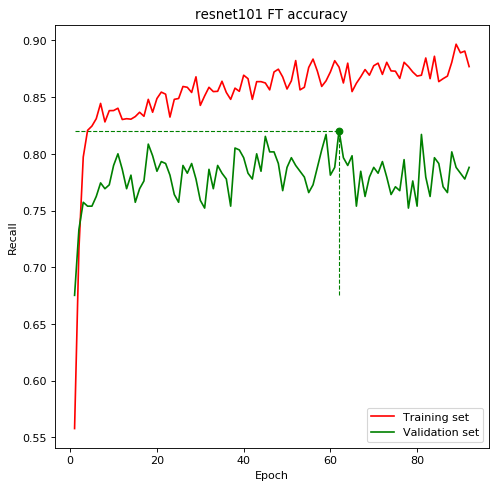

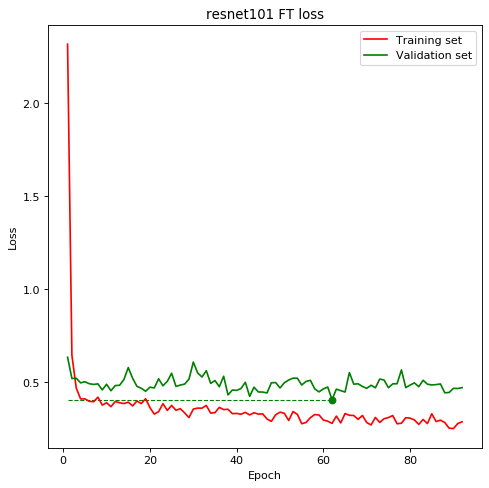

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [22]:
resnet101_calc_or_mass_best_SGD = create_resnet101(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_calc_or_mass_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_calc_or_mass_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_resnet101_calc_or_mass_best_SGD = resnet101_calc_or_mass_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5433 - recall: 0.4852
Epoch 00001: val_loss improved from inf to 0.87249, saving model to ../model/resnet101_calc_or_mass_best_SGD.h5
11/11 [==============================] - 26s 2s/step - loss: 1.5087 - recall: 0.4929 - val_loss: 0.8725 - val_recall: 0.5470
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2149 - recall: 0.5606
Epoch 00002: val_loss improved from 0.87249 to 0.86005, saving model to ../model/resnet101_calc_or_mass_best_SGD.h5
11/11 [==============================] - 21s 2s/step - loss: 1.2015 - recall: 0.5631 - val_loss: 0.8600 - val_recall: 0.5419
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2180 - recall: 0.5572
Epoch 00003: val_loss improved from 0.86005 to 0.77501, saving model to ../model/resnet101_calc_or_mass_best_SGD.h5
11/11 [=============================

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6672 - recall: 0.7163
Epoch 00028: val_loss did not improve from 0.57134
11/11 [==============================] - 20s 2s/step - loss: 0.6610 - recall: 0.7249 - val_loss: 0.6017 - val_recall: 0.6838
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6948 - recall: 0.7063
Epoch 00029: val_loss did not improve from 0.57134
11/11 [==============================] - 22s 2s/step - loss: 0.6861 - recall: 0.7060 - val_loss: 0.6082 - val_recall: 0.6889
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6406 - recall: 0.7289
Epoch 00030: val_loss did not improve from 0.57134
11/11 [==============================] - 21s 2s/step - loss: 0.6460 - recall: 0.7315 - val_loss: 0.5818 - val_recall: 0.6838
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6299 - recall: 0.7298
Epoch 00031: val_loss improved from 0.57134 to 0.55719, saving model to ../model/resnet101_calc_

Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5510 - recall: 0.7551
Epoch 00058: val_loss did not improve from 0.53011
11/11 [==============================] - 21s 2s/step - loss: 0.5459 - recall: 0.7599 - val_loss: 0.6096 - val_recall: 0.6821
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6010 - recall: 0.7406
Epoch 00059: val_loss did not improve from 0.53011
11/11 [==============================] - 22s 2s/step - loss: 0.5939 - recall: 0.7436 - val_loss: 0.5601 - val_recall: 0.7128
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6049 - recall: 0.7416
Epoch 00060: val_loss did not improve from 0.53011
11/11 [==============================] - 21s 2s/step - loss: 0.6021 - recall: 0.7416 - val_loss: 0.5619 - val_recall: 0.7060
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5481 - recall: 0.7601
Epoch 00061: val_loss did not improve from 0.53011
11/11 [==============================] - 21s 

Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5629 - recall: 0.7492
Epoch 00088: val_loss did not improve from 0.51869
11/11 [==============================] - 20s 2s/step - loss: 0.5619 - recall: 0.7515 - val_loss: 0.5406 - val_recall: 0.7402
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5700 - recall: 0.7601
Epoch 00089: val_loss did not improve from 0.51869
11/11 [==============================] - 21s 2s/step - loss: 0.5781 - recall: 0.7576 - val_loss: 0.5479 - val_recall: 0.7145
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5316 - recall: 0.7555
Epoch 00090: val_loss did not improve from 0.51869
11/11 [==============================] - 23s 2s/step - loss: 0.5353 - recall: 0.7528 - val_loss: 0.5564 - val_recall: 0.6957
Epoch 91/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5574 - recall: 0.7424
Epoch 00091: val_loss did not improve from 0.51869
11/11 [==============================] - 21s 

Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5247 - recall: 0.7594
Epoch 00118: val_loss did not improve from 0.49572
11/11 [==============================] - 21s 2s/step - loss: 0.5265 - recall: 0.7599 - val_loss: 0.5296 - val_recall: 0.7265
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5242 - recall: 0.7523
Epoch 00119: val_loss did not improve from 0.49572
11/11 [==============================] - 22s 2s/step - loss: 0.5170 - recall: 0.7550 - val_loss: 0.5338 - val_recall: 0.7402
Epoch 120/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4788 - recall: 0.7811
Epoch 00120: val_loss did not improve from 0.49572
11/11 [==============================] - 21s 2s/step - loss: 0.4700 - recall: 0.7850 - val_loss: 0.5504 - val_recall: 0.7128
Epoch 121/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5157 - recall: 0.7648
Epoch 00121: val_loss did not improve from 0.49572
11/11 [==============================] - 

In [24]:
models.save_model(resnet101_calc_or_mass_best_SGD, '../model/resnet101_calc_or_mass_end_SGD.h5')

In [25]:
tra_loss_fe = history_resnet101_calc_or_mass_best_SGD.history['loss']
tra_acc_fe = history_resnet101_calc_or_mass_best_SGD.history['recall']
val_loss_fe = history_resnet101_calc_or_mass_best_SGD.history['val_loss']
val_acc_fe = history_resnet101_calc_or_mass_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_calc_or_mass = models.load_model('../model/resnet101_calc_or_mass_best_SGD.h5')
test_loss_fe, test_acc_fe = resnet101_calc_or_mass_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet101 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 calc or mass

Epoch [end]: 132
Epoch [opt]: 102
Valid recall [end]: 0.7231
Valid recall [opt]: 0.7556
Test recall [end]:  0.7481
Test recall [opt]:  0.7465
Valid loss [end]: 0.5233
Valid loss [opt]: 0.4957
Test loss [end]:  0.4899
Test loss [opt]:  0.5029


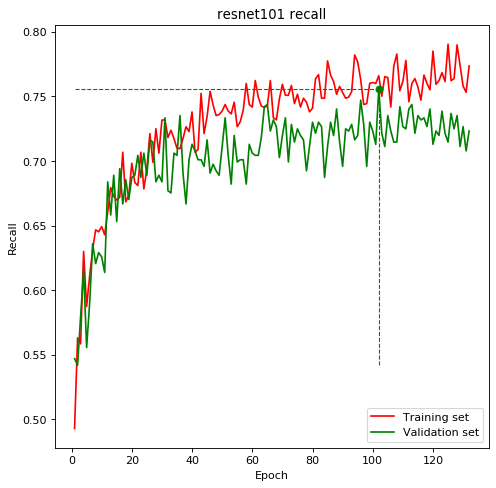

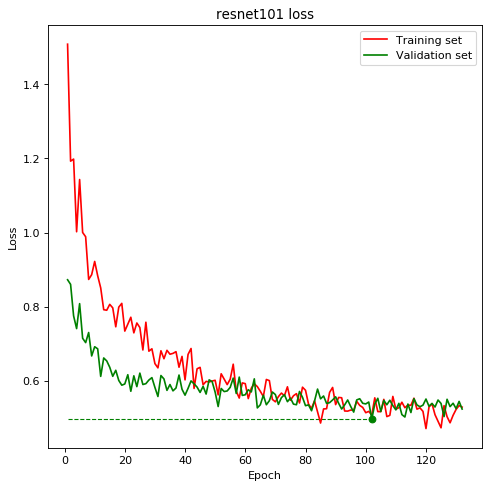

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [27]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_calc_or_mass_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_calc_or_mass_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [28]:
# Train
history_resnet101_calc_or_mass_best_RMSprop = resnet101_calc_or_mass_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7658 - recall: 0.8000
Epoch 00001: val_loss improved from inf to 0.48069, saving model to ../model/resnet101_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 27s 2s/step - loss: 0.7238 - recall: 0.8061 - val_loss: 0.4807 - val_recall: 0.7556
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3549 - recall: 0.8570
Epoch 00002: val_loss did not improve from 0.48069
11/11 [==============================] - 22s 2s/step - loss: 0.3740 - recall: 0.8466 - val_loss: 0.5930 - val_recall: 0.7402
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3819 - recall: 0.8493
Epoch 00003: val_loss improved from 0.48069 to 0.46395, saving model to ../model/resnet101_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 23s 2s/step - loss: 0.3779 - recall: 0.8488 - val_lo

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3018 - recall: 0.8672
Epoch 00029: val_loss improved from 0.41916 to 0.40075, saving model to ../model/resnet101_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 24s 2s/step - loss: 0.3018 - recall: 0.8679 - val_loss: 0.4007 - val_recall: 0.8342
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2813 - recall: 0.8789
Epoch 00030: val_loss did not improve from 0.40075
11/11 [==============================] - 22s 2s/step - loss: 0.2788 - recall: 0.8800 - val_loss: 0.4371 - val_recall: 0.8085
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3044 - recall: 0.8805
Epoch 00031: val_loss did not improve from 0.40075
11/11 [==============================] - 21s 2s/step - loss: 0.3078 - recall: 0.8777 - val_loss: 0.4380 - val_recall: 0.8120
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2735 - recall: 0.8931
Epoch 00032: val_loss did n

In [29]:
models.save_model(resnet101_calc_or_mass_best_RMSprop, '../model/resnet101_calc_or_mass_end_RMSprop.h5')

In [30]:
tra_loss_fe = history_resnet101_calc_or_mass_best_RMSprop.history['loss']
tra_acc_fe = history_resnet101_calc_or_mass_best_RMSprop.history['recall']
val_loss_fe = history_resnet101_calc_or_mass_best_RMSprop.history['val_loss']
val_acc_fe = history_resnet101_calc_or_mass_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_calc_or_mass = models.load_model('../model/resnet101_calc_or_mass_best_RMSprop.h5')
test_loss_fe, test_acc_fe = resnet101_calc_or_mass_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet101 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 calc or mass

Epoch [end]: 59
Epoch [opt]: 29
Valid recall [end]: 0.8188
Valid recall [opt]: 0.8342
Test recall [end]:  0.7792
Test recall [opt]:  0.7932
Valid loss [end]: 0.4604
Valid loss [opt]: 0.4007
Test loss [end]:  0.4871
Test loss [opt]:  0.5040


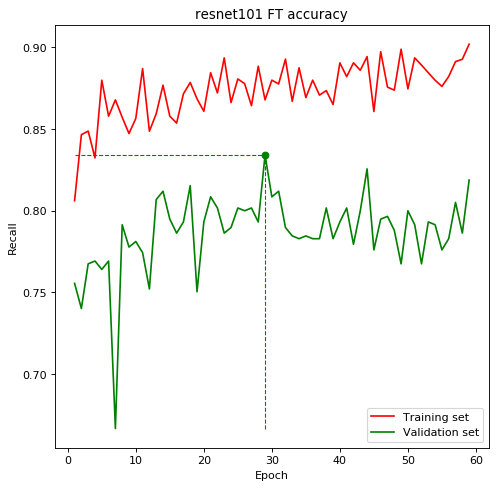

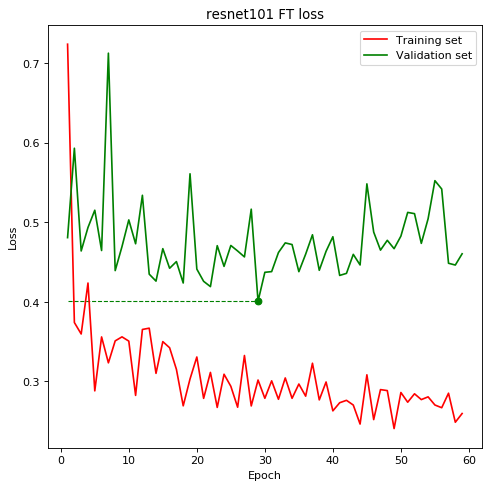

In [31]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [32]:
resnet101_calc_or_mass_best_Adadelta = create_resnet101(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_calc_or_mass_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_calc_or_mass_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [33]:
# Train
history_resnet101_calc_or_mass_best_Adadelta = resnet101_calc_or_mass_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3788 - recall: 0.5016
Epoch 00001: val_loss improved from inf to 1.26005, saving model to ../model/resnet101_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 25s 2s/step - loss: 1.3737 - recall: 0.5000 - val_loss: 1.2601 - val_recall: 0.4085
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3816 - recall: 0.4983
Epoch 00002: val_loss improved from 1.26005 to 1.23983, saving model to ../model/resnet101_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 1.4169 - recall: 0.4916 - val_loss: 1.2398 - val_recall: 0.4034
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4431 - recall: 0.5055
Epoch 00003: val_loss improved from 1.23983 to 1.16595, saving model to ../model/resnet101_calc_or_mass_best_Adadelta.h5
11/11 [==============

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2527 - recall: 0.5328
Epoch 00029: val_loss did not improve from 1.08315
11/11 [==============================] - 22s 2s/step - loss: 1.2239 - recall: 0.5369 - val_loss: 1.1764 - val_recall: 0.4632
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2324 - recall: 0.5513
Epoch 00030: val_loss did not improve from 1.08315
11/11 [==============================] - 22s 2s/step - loss: 1.2488 - recall: 0.5464 - val_loss: 1.1596 - val_recall: 0.4632
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2897 - recall: 0.5320
Epoch 00031: val_loss did not improve from 1.08315
11/11 [==============================] - 22s 2s/step - loss: 1.2625 - recall: 0.5405 - val_loss: 1.1350 - val_recall: 0.4496
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2028 - recall: 0.5445
Epoch 00032: val_loss did not improve from 1.08315
11/11 [==============================] - 21s 

Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0327 - recall: 0.5875
Epoch 00089: val_loss improved from 1.03199 to 1.02266, saving model to ../model/resnet101_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 1.0394 - recall: 0.5904 - val_loss: 1.0227 - val_recall: 0.5162
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0446 - recall: 0.6002
Epoch 00090: val_loss did not improve from 1.02266
11/11 [==============================] - 21s 2s/step - loss: 1.0472 - recall: 0.5935 - val_loss: 1.0745 - val_recall: 0.5077
Epoch 91/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1007 - recall: 0.5682
Epoch 00091: val_loss did not improve from 1.02266
11/11 [==============================] - 22s 2s/step - loss: 1.0986 - recall: 0.5722 - val_loss: 1.0995 - val_recall: 0.5179
Epoch 92/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0571 - recall: 0.5648
Epoch 00092: val_loss did 

10/11 [==========================>...] - ETA: 1s - loss: 0.9056 - recall: 0.6461
Epoch 00148: val_loss did not improve from 0.99942
11/11 [==============================] - 23s 2s/step - loss: 0.9052 - recall: 0.6470 - val_loss: 1.0962 - val_recall: 0.5043
Epoch 149/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9312 - recall: 0.6359
Epoch 00149: val_loss did not improve from 0.99942
11/11 [==============================] - 21s 2s/step - loss: 0.9314 - recall: 0.6335 - val_loss: 1.0371 - val_recall: 0.5214
Epoch 150/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9836 - recall: 0.6336
Epoch 00150: val_loss did not improve from 0.99942
11/11 [==============================] - 22s 2s/step - loss: 0.9938 - recall: 0.6293 - val_loss: 1.0636 - val_recall: 0.5265
Epoch 151/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9056 - recall: 0.6367
Epoch 00151: val_loss did not improve from 0.99942
11/11 [==============================] - 22s 2s/step - 

Epoch 178/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8936 - recall: 0.6508
Epoch 00178: val_loss did not improve from 0.96428
11/11 [==============================] - 21s 2s/step - loss: 0.8900 - recall: 0.6562 - val_loss: 0.9989 - val_recall: 0.5368
Epoch 179/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9119 - recall: 0.6484
Epoch 00179: val_loss did not improve from 0.96428
11/11 [==============================] - 21s 2s/step - loss: 0.9094 - recall: 0.6470 - val_loss: 1.0392 - val_recall: 0.5385
Epoch 180/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8654 - recall: 0.6461
Epoch 00180: val_loss did not improve from 0.96428
11/11 [==============================] - 22s 2s/step - loss: 0.8595 - recall: 0.6470 - val_loss: 1.0222 - val_recall: 0.5350
Epoch 181/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9011 - recall: 0.6469
Epoch 00181: val_loss did not improve from 0.96428
11/11 [==============================] - 

In [34]:
models.save_model(resnet101_calc_or_mass_best_Adadelta, '../model/resnet101_calc_or_mass_end_Adadelta.h5')

In [35]:
tra_loss_fe = history_resnet101_calc_or_mass_best_Adadelta.history['loss']
tra_acc_fe = history_resnet101_calc_or_mass_best_Adadelta.history['recall']
val_loss_fe = history_resnet101_calc_or_mass_best_Adadelta.history['val_loss']
val_acc_fe = history_resnet101_calc_or_mass_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_calc_or_mass = models.load_model('../model/resnet101_calc_or_mass_best_Adadelta.h5')
test_loss_fe, test_acc_fe = resnet101_calc_or_mass_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet101 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 calc or mass

Epoch [end]: 196
Epoch [opt]: 166
Valid recall [end]: 0.5402
Valid recall [opt]: 0.5282
Test recall [end]:  0.5319
Test recall [opt]:  0.5288
Valid loss [end]: 1.0149
Valid loss [opt]: 0.9643
Test loss [end]:  1.2072
Test loss [opt]:  1.2265


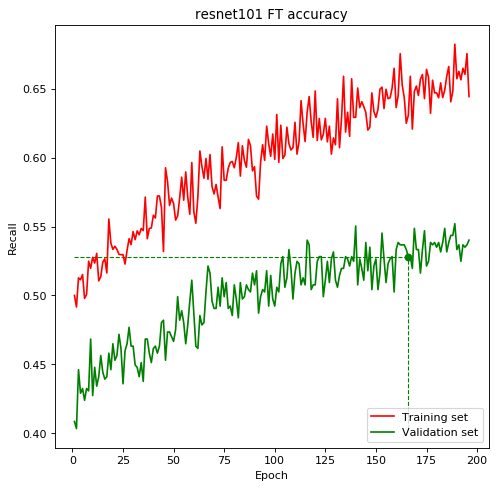

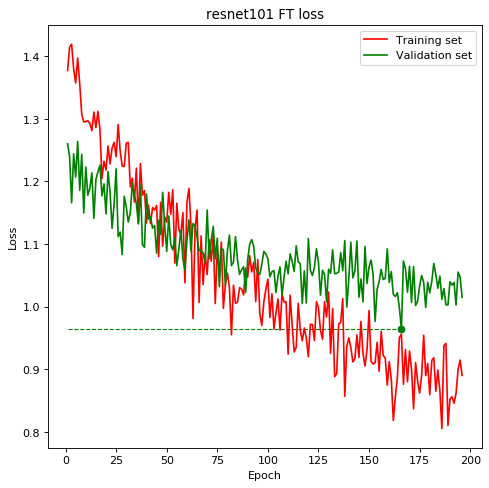

In [36]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [15]:
resnet101_calc_or_mass_best_Adagrad = create_resnet101(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_calc_or_mass_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_calc_or_mass_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_resnet101_calc_or_mass_best_Adagrad = resnet101_calc_or_mass_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4072 - recall: 0.5523
Epoch 00001: val_loss improved from inf to 0.78501, saving model to ../model/resnet101_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 27s 2s/step - loss: 1.4214 - recall: 0.5547 - val_loss: 0.7850 - val_recall: 0.6359
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1287 - recall: 0.6136
Epoch 00002: val_loss did not improve from 0.78501
11/11 [==============================] - 21s 2s/step - loss: 1.0935 - recall: 0.6216 - val_loss: 0.8304 - val_recall: 0.6137
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9665 - recall: 0.6617
Epoch 00003: val_loss improved from 0.78501 to 0.74889, saving model to ../model/resnet101_calc_or_mass_best_Adagrad.h5
11/11 [==========

Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5089 - recall: 0.7695
Epoch 00056: val_loss did not improve from 0.56125
11/11 [==============================] - 22s 2s/step - loss: 0.5043 - recall: 0.7699 - val_loss: 0.5835 - val_recall: 0.7077
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4917 - recall: 0.7778
Epoch 00057: val_loss did not improve from 0.56125
11/11 [==============================] - 21s 2s/step - loss: 0.4903 - recall: 0.7751 - val_loss: 0.6086 - val_recall: 0.6752
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4761 - recall: 0.7837
Epoch 00058: val_loss did not improve from 0.56125
11/11 [==============================] - 21s 2s/step - loss: 0.4767 - recall: 0.7842 - val_loss: 0.5649 - val_recall: 0.7060
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4692 - recall: 0.7719
Epoch 00059: val_loss did not improve from 0.56125
11/11 [==============================] - 21s 

10/11 [==========================>...] - ETA: 1s - loss: 0.4220 - recall: 0.8094
Epoch 00115: val_loss did not improve from 0.53079
11/11 [==============================] - 22s 2s/step - loss: 0.4198 - recall: 0.8125 - val_loss: 0.5932 - val_recall: 0.7009
Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4445 - recall: 0.7883
Epoch 00116: val_loss did not improve from 0.53079
11/11 [==============================] - 22s 2s/step - loss: 0.4391 - recall: 0.7933 - val_loss: 0.5833 - val_recall: 0.6991
Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4428 - recall: 0.7896
Epoch 00117: val_loss did not improve from 0.53079
11/11 [==============================] - 21s 2s/step - loss: 0.4381 - recall: 0.7918 - val_loss: 0.5700 - val_recall: 0.7162
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4385 - recall: 0.7837
Epoch 00118: val_loss did not improve from 0.53079
11/11 [==============================] - 21s 2s/step - 

10/11 [==========================>...] - ETA: 1s - loss: 0.4542 - recall: 0.8016
Epoch 00145: val_loss did not improve from 0.51128
11/11 [==============================] - 22s 2s/step - loss: 0.4600 - recall: 0.7997 - val_loss: 0.5333 - val_recall: 0.7299
Epoch 146/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4105 - recall: 0.8072
Epoch 00146: val_loss did not improve from 0.51128
11/11 [==============================] - 21s 2s/step - loss: 0.4213 - recall: 0.8024 - val_loss: 0.5638 - val_recall: 0.6855
Epoch 147/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4438 - recall: 0.8039
Epoch 00147: val_loss did not improve from 0.51128
11/11 [==============================] - 22s 2s/step - loss: 0.4392 - recall: 0.8026 - val_loss: 0.5477 - val_recall: 0.7214
Epoch 148/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4277 - recall: 0.8005
Epoch 00148: val_loss did not improve from 0.51128
11/11 [==============================] - 20s 2s/step - 

In [17]:
models.save_model(resnet101_calc_or_mass_best_Adagrad, '../model/resnet101_calc_or_mass_end_Adagrad.h5')

In [18]:
tra_loss_fe = history_resnet101_calc_or_mass_best_Adagrad.history['loss']
tra_acc_fe = history_resnet101_calc_or_mass_best_Adagrad.history['recall']
val_loss_fe = history_resnet101_calc_or_mass_best_Adagrad.history['val_loss']
val_acc_fe = history_resnet101_calc_or_mass_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_calc_or_mass = models.load_model('../model/resnet101_calc_or_mass_best_Adagrad.h5')
test_loss_fe, test_acc_fe = resnet101_calc_or_mass_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet101 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 calc or mass

Epoch [end]: 158
Epoch [opt]: 128
Valid recall [end]: 0.7282
Valid recall [opt]: 0.7504
Test recall [end]:  0.7512
Test recall [opt]:  0.7449
Valid loss [end]: 0.5476
Valid loss [opt]: 0.5113
Test loss [end]:  0.5099
Test loss [opt]:  0.5220


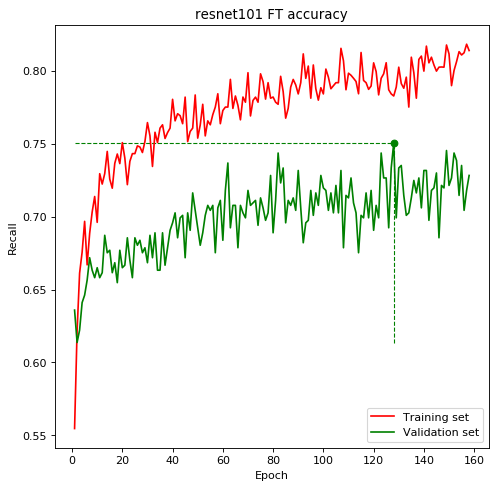

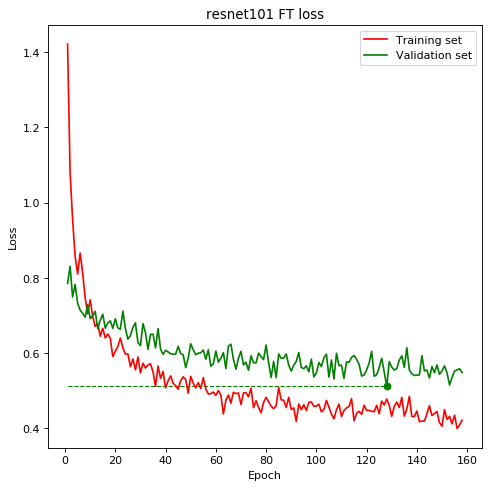

In [19]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [17]:
resnet101_calc_or_mass_best_Adamax = create_resnet101(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_calc_or_mass_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_calc_or_mass_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [18]:
# Train
history_resnet101_calc_or_mass_best_Adamax = resnet101_calc_or_mass_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 3.2446 - recall: 0.5648
Epoch 00001: val_loss improved from inf to 0.64643, saving model to ../model/resnet101_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 26s 2s/step - loss: 2.9791 - recall: 0.5684 - val_loss: 0.6464 - val_recall: 0.5726
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6282 - recall: 0.6675
Epoch 00002: val_loss did not improve from 0.64643
11/11 [==============================] - 20s 2s/step - loss: 0.6277 - recall: 0.6687 - val_loss: 0.6477 - val_recall: 0.6256
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6266 - recall: 0.6641
Epoch 00003: val_loss improved from 0.64643 to 0.63370, saving model to ../model/resnet101_calc_or_mass_best_Adamax.h5
11/11 [============

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3747 - recall: 0.8359
Epoch 00027: val_loss did not improve from 0.46761
11/11 [==============================] - 22s 2s/step - loss: 0.3632 - recall: 0.8409 - val_loss: 0.5331 - val_recall: 0.7402
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3808 - recall: 0.8375
Epoch 00028: val_loss did not improve from 0.46761
11/11 [==============================] - 20s 2s/step - loss: 0.3834 - recall: 0.8305 - val_loss: 0.5017 - val_recall: 0.7402
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4008 - recall: 0.8148
Epoch 00029: val_loss did not improve from 0.46761
11/11 [==============================] - 22s 2s/step - loss: 0.3998 - recall: 0.8146 - val_loss: 0.5014 - val_recall: 0.7692
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3839 - recall: 0.8164
Epoch 00030: val_loss did not improve from 0.46761
11/11 [==============================] - 21s 

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3404 - recall: 0.8451
Epoch 00057: val_loss did not improve from 0.44054
11/11 [==============================] - 20s 2s/step - loss: 0.3417 - recall: 0.8435 - val_loss: 0.4569 - val_recall: 0.7897
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3243 - recall: 0.8586
Epoch 00058: val_loss improved from 0.44054 to 0.44038, saving model to ../model/resnet101_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 22s 2s/step - loss: 0.3228 - recall: 0.8609 - val_loss: 0.4404 - val_recall: 0.7812
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3478 - recall: 0.8461
Epoch 00059: val_loss did not improve from 0.44038
11/11 [==============================] - 22s 2s/step - loss: 0.3515 - recall: 0.8430 - val_loss: 0.4726 - val_recall: 0.7624
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3264 - recall: 0.8535
Epoch 00060: val_loss did no

Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2756 - recall: 0.8796
Epoch 00116: val_loss did not improve from 0.41764
11/11 [==============================] - 21s 2s/step - loss: 0.2758 - recall: 0.8792 - val_loss: 0.4329 - val_recall: 0.7863
Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2954 - recall: 0.8766
Epoch 00117: val_loss did not improve from 0.41764
11/11 [==============================] - 22s 2s/step - loss: 0.2996 - recall: 0.8700 - val_loss: 0.4270 - val_recall: 0.7949
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2974 - recall: 0.8712
Epoch 00118: val_loss did not improve from 0.41764
11/11 [==============================] - 20s 2s/step - loss: 0.2918 - recall: 0.8784 - val_loss: 0.4312 - val_recall: 0.7897
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2892 - recall: 0.8569
Epoch 00119: val_loss improved from 0.41764 to 0.41725, saving model to ../model/resnet101_c

Epoch 146/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2728 - recall: 0.8847
Epoch 00146: val_loss did not improve from 0.40681
11/11 [==============================] - 21s 2s/step - loss: 0.2734 - recall: 0.8853 - val_loss: 0.4296 - val_recall: 0.7983
Epoch 147/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2951 - recall: 0.8695
Epoch 00147: val_loss did not improve from 0.40681
11/11 [==============================] - 21s 2s/step - loss: 0.2937 - recall: 0.8701 - val_loss: 0.4250 - val_recall: 0.8085
Epoch 148/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3186 - recall: 0.8609
Epoch 00148: val_loss did not improve from 0.40681
11/11 [==============================] - 22s 2s/step - loss: 0.3181 - recall: 0.8601 - val_loss: 0.4132 - val_recall: 0.8137
Epoch 149/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3070 - recall: 0.8766
Epoch 00149: val_loss did not improve from 0.40681
11/11 [==============================] - 

Epoch 176/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2744 - recall: 0.8836
Epoch 00176: val_loss did not improve from 0.40582
11/11 [==============================] - 21s 2s/step - loss: 0.2750 - recall: 0.8849 - val_loss: 0.4227 - val_recall: 0.7949
Epoch 177/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2815 - recall: 0.8758
Epoch 00177: val_loss did not improve from 0.40582
11/11 [==============================] - 21s 2s/step - loss: 0.2833 - recall: 0.8736 - val_loss: 0.4105 - val_recall: 0.8051
Epoch 178/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2905 - recall: 0.8828
Epoch 00178: val_loss did not improve from 0.40582
11/11 [==============================] - 20s 2s/step - loss: 0.2765 - recall: 0.8860 - val_loss: 0.4127 - val_recall: 0.7966
Epoch 179/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2685 - recall: 0.8867
Epoch 00179: val_loss did not improve from 0.40582
11/11 [==============================] - 

In [19]:
models.save_model(resnet101_calc_or_mass_best_Adamax, '../model/resnet101_calc_or_mass_end_Adamax.h5')

In [20]:
tra_loss_fe = history_resnet101_calc_or_mass_best_Adamax.history['loss']
tra_acc_fe = history_resnet101_calc_or_mass_best_Adamax.history['recall']
val_loss_fe = history_resnet101_calc_or_mass_best_Adamax.history['val_loss']
val_acc_fe = history_resnet101_calc_or_mass_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_calc_or_mass = models.load_model('../model/resnet101_calc_or_mass_best_Adamax.h5')
test_loss_fe, test_acc_fe = resnet101_calc_or_mass_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet101 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 calc or mass

Epoch [end]: 188
Epoch [opt]: 158
Valid recall [end]: 0.8188
Valid recall [opt]: 0.8000
Test recall [end]:  0.8149
Test recall [opt]:  0.8149
Valid loss [end]: 0.4254
Valid loss [opt]: 0.4058
Test loss [end]:  0.4155
Test loss [opt]:  0.4092


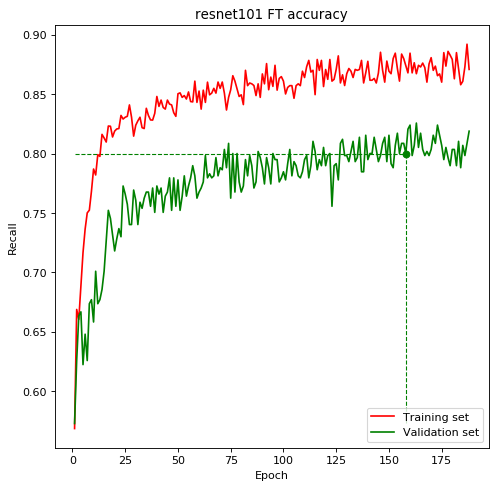

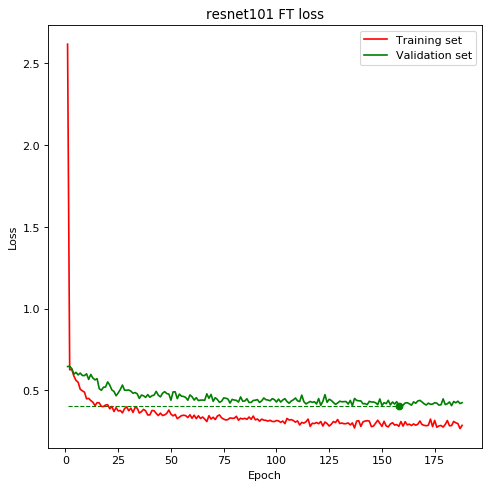

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [22]:
resnet101_calc_or_mass_best_Nadam = create_resnet101(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_calc_or_mass_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_calc_or_mass_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_resnet101_calc_or_mass_best_Nadam = resnet101_calc_or_mass_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.8718 - recall: 0.6117
Epoch 00001: val_loss improved from inf to 0.85732, saving model to ../model/resnet101_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 24s 2s/step - loss: 1.7549 - recall: 0.6140 - val_loss: 0.8573 - val_recall: 0.5453
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5608 - recall: 0.7188
Epoch 00002: val_loss improved from 0.85732 to 0.61573, saving model to ../model/resnet101_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 23s 2s/step - loss: 0.5603 - recall: 0.7180 - val_loss: 0.6157 - val_recall: 0.6513
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5124 - recall: 0.7525
Epoch 00003: val_loss improved from 0.61573 to 0.60768, saving model to ../model/resnet101_calc_or_mass_best_Nadam.h5
11/11 [=======================

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3415 - recall: 0.8569
Epoch 00029: val_loss did not improve from 0.45700
11/11 [==============================] - 21s 2s/step - loss: 0.3427 - recall: 0.8556 - val_loss: 0.5161 - val_recall: 0.7368
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3168 - recall: 0.8586
Epoch 00030: val_loss did not improve from 0.45700
11/11 [==============================] - 22s 2s/step - loss: 0.3129 - recall: 0.8580 - val_loss: 0.4750 - val_recall: 0.7692
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2801 - recall: 0.8771
Epoch 00031: val_loss did not improve from 0.45700
11/11 [==============================] - 20s 2s/step - loss: 0.2855 - recall: 0.8739 - val_loss: 0.5063 - val_recall: 0.7231
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3279 - recall: 0.8625
Epoch 00032: val_loss improved from 0.45700 to 0.45163, saving model to ../model/resnet101_calc_

Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2881 - recall: 0.8653
Epoch 00058: val_loss did not improve from 0.42320
11/11 [==============================] - 20s 2s/step - loss: 0.2916 - recall: 0.8625 - val_loss: 0.4363 - val_recall: 0.8068
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2923 - recall: 0.8729
Epoch 00059: val_loss did not improve from 0.42320
11/11 [==============================] - 21s 2s/step - loss: 0.2911 - recall: 0.8761 - val_loss: 0.4300 - val_recall: 0.7915
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3115 - recall: 0.8609
Epoch 00060: val_loss did not improve from 0.42320
11/11 [==============================] - 22s 2s/step - loss: 0.3100 - recall: 0.8622 - val_loss: 0.4275 - val_recall: 0.7966
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2891 - recall: 0.8703
Epoch 00061: val_loss did not improve from 0.42320
11/11 [==============================] - 21s 

10/11 [==========================>...] - ETA: 1s - loss: 0.2471 - recall: 0.8914
Epoch 00117: val_loss did not improve from 0.37629
11/11 [==============================] - 21s 2s/step - loss: 0.2590 - recall: 0.8837 - val_loss: 0.4594 - val_recall: 0.7778
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2565 - recall: 0.8864
Epoch 00118: val_loss did not improve from 0.37629
11/11 [==============================] - 21s 2s/step - loss: 0.2592 - recall: 0.8868 - val_loss: 0.4275 - val_recall: 0.7915
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2687 - recall: 0.8712
Epoch 00119: val_loss did not improve from 0.37629
11/11 [==============================] - 21s 2s/step - loss: 0.2691 - recall: 0.8716 - val_loss: 0.4406 - val_recall: 0.7880
Epoch 120/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2566 - recall: 0.8852
Epoch 00120: val_loss did not improve from 0.37629
11/11 [==============================] - 22s 2s/step - 

In [24]:
models.save_model(resnet101_calc_or_mass_best_Nadam, '../model/resnet101_calc_or_mass_end_Nadam.h5')

In [25]:
tra_loss_fe = history_resnet101_calc_or_mass_best_Nadam.history['loss']
tra_acc_fe = history_resnet101_calc_or_mass_best_Nadam.history['recall']
val_loss_fe = history_resnet101_calc_or_mass_best_Nadam.history['val_loss']
val_acc_fe = history_resnet101_calc_or_mass_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_calc_or_mass = models.load_model('../model/resnet101_calc_or_mass_best_Nadam.h5')
test_loss_fe, test_acc_fe = resnet101_calc_or_mass_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet101 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 calc or mass

Epoch [end]: 143
Epoch [opt]: 113
Valid recall [end]: 0.8137
Valid recall [opt]: 0.8154
Test recall [end]:  0.8040
Test recall [opt]:  0.8040
Valid loss [end]: 0.4190
Valid loss [opt]: 0.3763
Test loss [end]:  0.4365
Test loss [opt]:  0.4454


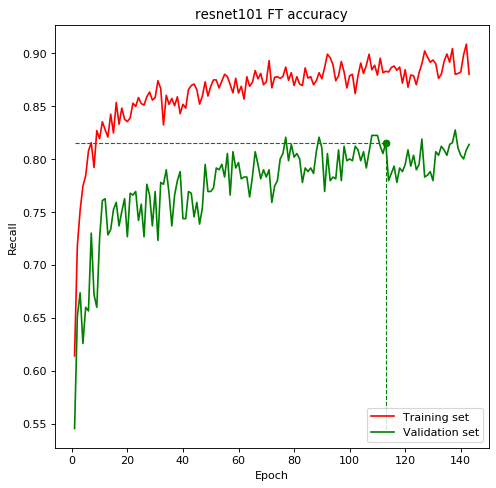

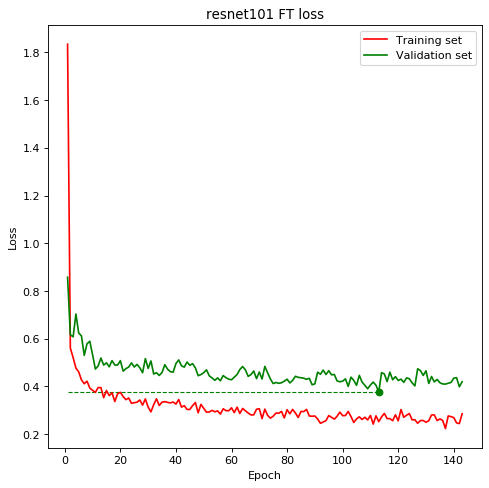

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [27]:
resnet101_calc_or_mass_fine_Adam = models.load_model('../model/resnet101_calc_or_mass_best_Adam.h5')

for layer in resnet101_calc_or_mass_fine_Adam.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet101_calc_or_mass_fine_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet101_calc_or_mass_fine_Adam.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [28]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet101_calc_or_mass_fine_Adam_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [29]:
history_fit = resnet101_calc_or_mass_fine_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3138 - recall: 0.8695
Epoch 00001: val_loss improved from inf to 0.45206, saving model to ../model/resnet101_calc_or_mass_fine_Adam_best.h5
11/11 [==============================] - 24s 2s/step - loss: 0.3157 - recall: 0.8678 - val_loss: 0.4521 - val_recall: 0.7880
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3382 - recall: 0.8602
Epoch 00002: val_loss improved from 0.45206 to 0.43689, saving model to ../model/resnet101_calc_or_mass_fine_Adam_best.h5
11/11 [==============================] - 24s 2s/step - loss: 0.3342 - recall: 0.8615 - val_loss: 0.4369 - val_recall: 0.8034
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2970 - recall: 0.8611
Epoch 00003: val_loss did not improve from 0.43689
11/11 [==============================] - 21s 2s/step - loss: 0.2966 - recall: 0.8625 - va

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3093 - recall: 0.8620
Epoch 00029: val_loss did not improve from 0.39759
11/11 [==============================] - 22s 2s/step - loss: 0.3139 - recall: 0.8602 - val_loss: 0.4452 - val_recall: 0.8103
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3401 - recall: 0.8519
Epoch 00030: val_loss did not improve from 0.39759
11/11 [==============================] - 22s 2s/step - loss: 0.3321 - recall: 0.8564 - val_loss: 0.4369 - val_recall: 0.8051
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2989 - recall: 0.8662
Epoch 00031: val_loss did not improve from 0.39759
11/11 [==============================] - 22s 2s/step - loss: 0.2973 - recall: 0.8670 - val_loss: 0.4572 - val_recall: 0.7795
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3054 - recall: 0.8727
Epoch 00032: val_loss did not improve from 0.39759
11/11 [==============================] - 22s 

In [30]:
models.save_model(resnet101_calc_or_mass_fine_Adam, '../model/resnet101_calc_or_mass_fine_Adam_end.h5')

In [31]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_calc_or_mass_fine_Adam = models.load_model('../model/resnet101_calc_or_mass_fine_Adam_best.h5')
test_loss_fe, test_acc_fe = resnet101_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)

print("resnet101 recall Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 recall Fine Tuning

Epoch [end]: 54
Epoch [opt]: 24
Valid recall [end]: 0.8239
Valid recall [opt]: 0.8171
Test recall [end]:  0.7776
Test recall [opt]:  0.7776
Valid loss [end]: 0.4119
Valid loss [opt]: 0.3976
Test loss [end]:  0.4783
Test loss [opt]:  0.4783


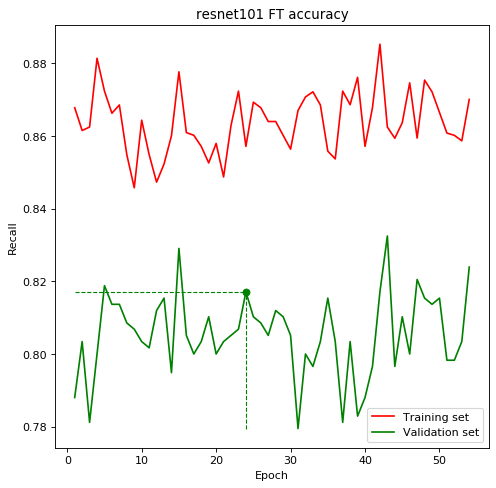

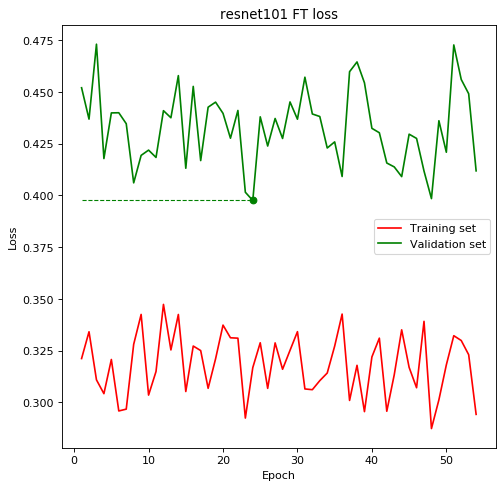

In [32]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [33]:
resnet101_calc_or_mass_fine_Adam2 = models.load_model('../model/resnet101_calc_or_mass_fine_Adam_best.h5')

for layer in resnet101_calc_or_mass_fine_Adam2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet101_calc_or_mass_fine_Adam2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet101_calc_or_mass_fine_Adam2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [34]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet101_calc_or_mass_fine_Adam_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [35]:
history_fit = resnet101_calc_or_mass_fine_Adam2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3257 - recall: 0.8594
Epoch 00001: val_loss improved from inf to 0.42251, saving model to ../model/resnet101_calc_or_mass_fine_Adam_best2.h5
11/11 [==============================] - 25s 2s/step - loss: 0.3180 - recall: 0.8643 - val_loss: 0.4225 - val_recall: 0.8154
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3127 - recall: 0.8527
Epoch 00002: val_loss improved from 0.42251 to 0.42202, saving model to ../model/resnet101_calc_or_mass_fine_Adam_best2.h5
11/11 [==============================] - 23s 2s/step - loss: 0.3116 - recall: 0.8549 - val_loss: 0.4220 - val_recall: 0.8171
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2902 - recall: 0.8695
Epoch 00003: val_loss did not improve from 0.42202
11/11 [==============================] - 21s 2s/step - loss: 0.2915 - recall: 0.8685 - 

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2967 - recall: 0.8727
Epoch 00029: val_loss did not improve from 0.38251
11/11 [==============================] - 23s 2s/step - loss: 0.2880 - recall: 0.8764 - val_loss: 0.4194 - val_recall: 0.7812
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3173 - recall: 0.8552
Epoch 00030: val_loss did not improve from 0.38251
11/11 [==============================] - 21s 2s/step - loss: 0.3159 - recall: 0.8579 - val_loss: 0.4541 - val_recall: 0.7983
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3193 - recall: 0.8672
Epoch 00031: val_loss did not improve from 0.38251
11/11 [==============================] - 23s 2s/step - loss: 0.3171 - recall: 0.8693 - val_loss: 0.4536 - val_recall: 0.8017
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2801 - recall: 0.8828
Epoch 00032: val_loss did not improve from 0.38251
11/11 [==============================] - 22s 

In [36]:
models.save_model(resnet101_calc_or_mass_fine_Adam2, '../model/resnet101_calc_or_mass_fine_Adam_end2.h5')

In [37]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_calc_or_mass_fine_Adam2 = models.load_model('../model/resnet101_calc_or_mass_fine_Adam_best2.h5')
test_loss_fe, test_acc_fe = resnet101_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)

print("resnet101 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 Fine Tuning

Epoch [end]: 54
Epoch [opt]: 24
Valid recall [end]: 0.8051
Valid recall [opt]: 0.8291
Test recall [end]:  0.7776
Test recall [opt]:  0.7776
Valid loss [end]: 0.4116
Valid loss [opt]: 0.3825
Test loss [end]:  0.4783
Test loss [opt]:  0.4783


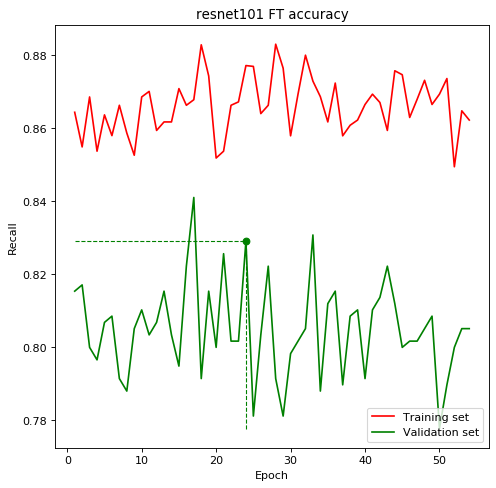

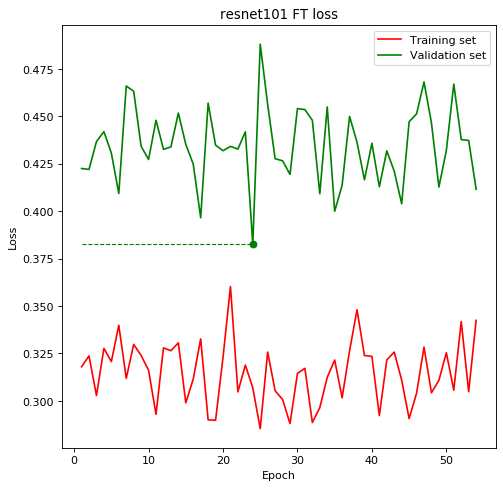

In [38]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [15]:
resnet101_calc_or_mass_fine_Adam3 = models.load_model('../model/resnet101_calc_or_mass_fine_Adam_best2.h5')

for layer in resnet101_calc_or_mass_fine_Adam3.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet101_calc_or_mass_fine_Adam3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet101_calc_or_mass_fine_Adam3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet101_calc_or_mass_fine_Adam_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [17]:
history_fit = resnet101_calc_or_mass_fine_Adam3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3316 - recall: 0.8602
Epoch 00001: val_loss improved from inf to 0.45391, saving model to ../model/resnet101_calc_or_mass_fine_Adam_best3.h5
11/11 [==============================] - 27s 2s/step - loss: 0.3266 - recall: 0.8615 - val_loss: 0.4539 - val_recall: 0.8103
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3251 - recall: 0.8678
Epoch 00002: val_loss improved from 0.45391 to 0.43170, saving model to ../model/resnet101_calc_or_mass_fine_Adam_best3.h5
11/11 [==============================] - 22s 2s/step - loss: 0.3283 - recall: 0.8640 - val_loss: 0.4317 - val_recall: 0.8068
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3296 - recall: 0.8561
Epoch 00003: val_loss improved from 0.43170 to 0.42825, saving

10/11 [==========================>...] - ETA: 1s - loss: 0.3299 - recall: 0.8611
Epoch 00028: val_loss did not improve from 0.42258
11/11 [==============================] - 21s 2s/step - loss: 0.3295 - recall: 0.8609 - val_loss: 0.4449 - val_recall: 0.8034
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3161 - recall: 0.8628
Epoch 00029: val_loss did not improve from 0.42258
11/11 [==============================] - 21s 2s/step - loss: 0.3223 - recall: 0.8594 - val_loss: 0.4596 - val_recall: 0.8120
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3031 - recall: 0.8628
Epoch 00030: val_loss did not improve from 0.42258
11/11 [==============================] - 22s 2s/step - loss: 0.3075 - recall: 0.8625 - val_loss: 0.4314 - val_recall: 0.8068
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3241 - recall: 0.8625
Epoch 00031: val_loss did not improve from 0.42258
11/11 [==============================] - 23s 2s/step - los

In [18]:
models.save_model(resnet101_calc_or_mass_fine_Adam3, '../model/resnet101_calc_or_mass_fine_Adam_end3.h5')

In [19]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_calc_or_mass_fine_Adam3 = models.load_model('../model/resnet101_calc_or_mass_fine_Adam_best3.h5')
test_loss_fe, test_acc_fe = resnet101_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)

print("resnet101 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 Fine Tuning

Epoch [end]: 39
Epoch [opt]: 9
Valid recall [end]: 0.8000
Valid recall [opt]: 0.8154
Test recall [end]:  0.7776
Test recall [opt]:  0.7776
Valid loss [end]: 0.4279
Valid loss [opt]: 0.4226
Test loss [end]:  0.4783
Test loss [opt]:  0.4783


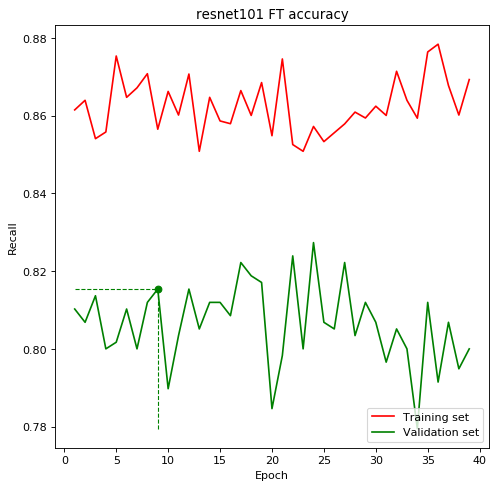

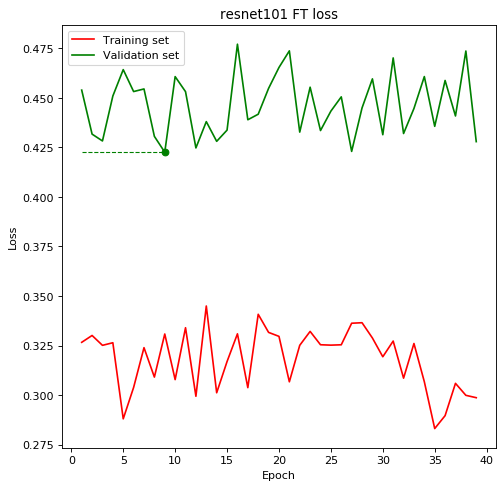

In [20]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();